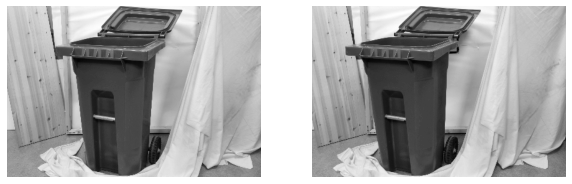

In [2]:
import numpy as np
import cv2
import matplotlib.pyplot as plt


# imgL_small = cv2.imread('Data/tsukuba/tsukuba_l.png', cv2.IMREAD_GRAYSCALE)
# imgR_small = cv2.imread('Data/tsukuba/tsukuba_R.png', cv2.IMREAD_GRAYSCALE)

# imgL = cv2.imread('Middlebury/MiddEval3-data-F/MiddEval3/trainingF/Pipes/im0.png', cv2.IMREAD_GRAYSCALE)
# imgR = cv2.imread('Middlebury/MiddEval3-data-F/MiddEval3/trainingF/Pipes/im1.png', cv2.IMREAD_GRAYSCALE)

imgL = cv2.imread('Data/Recycle-perfect/im0.png', cv2.IMREAD_GRAYSCALE)
imgR = cv2.imread('Data/Recycle-perfect/im1.png', cv2.IMREAD_GRAYSCALE)
imgL_small = cv2.resize(imgL, (0,0), fx=1/7, fy=1/7) 
imgR_small = cv2.resize(imgR, (0,0), fx=1/7, fy=1/7) 
fig = plt.figure(figsize=(10, 7))
fig.add_subplot(1, 2, 1)
plt.imshow(imgL_small, cmap='gray')
plt.axis('off')
fig.add_subplot(1, 2, 2)
plt.imshow(imgR_small, cmap='gray')
plt.axis('off')
plt.show()

In [197]:
# calculate disparity map using the block matching algorithm
fx = 2945.377        # lense focal length
baseline = 178.232  # distance in mm between the two cameras
disparities = 32   # num of disparities to consider
block = 8          # block size to match
units = 0.001       # depth units

print(imgL_small.shape)

disparity = np.zeros_like(imgR_small)

for i in range(block, imgL_small.shape[0] - block - 1):
    # print(i)
    for j in range(block + disparities, imgL_small.shape[1] - block - 1):
        ssd = np.empty([disparities, 1])

        # calc SSD at all possible disparities
        l = imgL_small[(i - block):(i + block), (j - block):(j + block)]
        for d in range(0, disparities):
            r = imgR_small[(i - block):(i + block), (j - d - block):(j - d + block)]
            ssd[d] = np.sum((l[:,:]-r[:,:])**2)

        # select the best match
        disparity[i, j] = np.argmin(ssd)

(275, 409)


In [3]:
def naive_stereo_bm_unique(imgL, imgR, disparities=32, block=8):
    # calculate disparity map using the block matching algorithm
    disparity = np.full_like(imgR.astype(float), -1)
    imgL_padded = np.pad(imgL, block, mode="reflect")
    imgR_padded = np.pad(imgR, block, mode="reflect")
    for i in range(imgL.shape[0]):
        ssd = np.full((imgL.shape[1],imgL.shape[1]),np.inf)
        mask = np.ones_like(ssd).astype(float).astype(float)
        for j in range(disparities,imgL.shape[1]):
            l_window = imgL_padded[i:i+2*block, j:j+2*block]
            for d in range(0, min(disparities, imgL.shape[1]-j-1)):
                r_window = imgR_padded[i:i+2*block, j-d:j-d+2*block]
                local_ssd = np.sum((l_window[:,:]-r_window[:,:])**2)
                # print(i,j,d, local_ssd)
                # print(l_window, r_window)
                ssd[j,j+d] = local_ssd
        for p in range(ssd.shape[0]):
            # select the best match
            ssd_masked = ssd*mask
            best_match = np.unravel_index(np.argmin(ssd_masked), ssd.shape)
            disparity[i,best_match[0]] = best_match[1]-best_match[0]
            mask[best_match[0],:] = np.inf
            mask[:,best_match[1]] = np.inf
    return disparity


In [10]:
disparity1 = naive_stereo_bm_unique(imgL_small, imgR_small)

In [6]:
print(np.min(disparity1))

-1.0


In [204]:
stereo = cv2.StereoBM_create(numDisparities=32, blockSize=block*2+1)
disparity2 = stereo.compute(imgL_small, imgR_small)

In [12]:
np.save("recycle_naive_r.npy",disparity1)

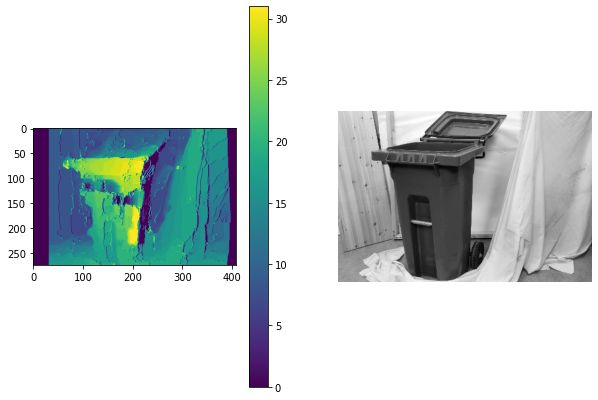

In [11]:

# fig = plt.figure(figsize=(10, 7))
# fig.add_subplot(1, 2, 1)
# plt.imshow(disparity)
# plt.colorbar()
# fig.add_subplot(1, 2, 2)
# plt.imshow(imgR_small, cmap='gray')
# plt.axis('off')
# plt.show()

fig = plt.figure(figsize=(10, 7))
fig.add_subplot(1, 2, 1)
plt.imshow((disparity1*(disparity1>=0)).astype("uint8"))
plt.colorbar()
fig.add_subplot(1, 2, 2)
plt.imshow(imgR_small, cmap='gray')
plt.axis('off')
plt.show()

# disparity2 = disparity2.astype(np.float32) / 16.0
# fig = plt.figure(figsize=(10, 7))
# fig.add_subplot(1, 2, 1)
# plt.imshow(disparity2)
# plt.colorbar()
# fig.add_subplot(1, 2, 2)
# plt.imshow(imgR_small, cmap='gray')
# plt.axis('off')
# plt.show()